# **Mini BTP - Options Pricing using Deep Learning**

Students: Visaj Nirav Shah (201801016), Dhruvil Bhatt (201801056)

Mentor: Prof. Jaideep Mulherkar

Objective:- We will predict options prices using two methods - Black-Scholes-Merton (BMS) model and a Deep Learning model. The expected outcome is that the Deep Learning model gives a better price prediction given the disadvantages of the BSM model.

Output:-


*   A large dataset with option prices and other required parameters
*   Implementation of a BSM price prediction model for Call and Put options
*   An efficient Deep Learning model built for options price prediction, each for Call and Put options
*   A comparison between the performance of the above two models


Reference:-

A. Ke and A. Yang, “Option pricing with deep learning,” 2019.

## **Importing required libraries**

In [1]:
# Importing required libraries

from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras import backend
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import log, sqrt, pi, exp
import math
import statistics

## **Importing the dataset**

Given the lack of existing options datasets for the Indian financial markets, we had to build a quality dataset from scratch. We collected relevant data from the NSE (National Stock Exchange) and RBI (Reserve Bank of India) websites.

The dataset contains all the Asian Paints (ASIANPAINT) Ltd. options traded from 2017-2020 (4 years).

All the options in this dataset are European options. No American options were traded in the selected timeframe.

This dataset is a significant output of this project, and if published, it can be useful to other researchers and professionals working in the domain of Indian financial markets.

The Call Options dataset is `df_call` and Put Options dataset is `df_put`.

In [2]:
# Call options

df_call = pd.read_excel('ASIANPAINT_Dataset.xlsx', sheet_name = [0, 2, 4, 6])
df_call = pd.concat([df_call[0], df_call[2], df_call[4], df_call[6]], axis=0)
df_call = df_call.drop(columns=['Date', 'Expiry'])

In [3]:
# Put options

df_put = pd.read_excel('ASIANPAINT_Dataset.xlsx', sheet_name = [1, 3, 5, 7])
df_put = pd.concat([df_put[1], df_put[3], df_put[5], df_put[7]], axis=0)
df_put = df_put.drop(columns=['Date', 'Expiry'])

## **Call Options**

### **Black-Scholes-Merton (BSM) Model**

In [4]:
def d1(S, K, T, r, sigma):
    return (np.log(S/K)+(r+sigma**2/2)*T)/sigma*sqrt(T)

def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

def black_scholes_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

In [5]:
total_iterations_call = len(df_call)
BSM_Price_Prediction_call = np.zeros(total_iterations_call)
Actual_Price_call = np.zeros(total_iterations_call)

for i in range(total_iterations_call):
  S = df_call.iloc[i]['underlying_value']
  K = df_call.iloc[i]['strike_price']
  T = df_call.iloc[i]['t']/252
  r = df_call.iloc[i]['r']
  sigma = df_call.iloc[i]['sigma']
  BSM_Price_Prediction_call[i] = max(0, black_scholes_call(S, K, T, r, sigma))
  Actual_Price_call[i] = df_call.iloc[i]['close']

In [6]:
# Calculating the MSE

BSM_MSE_call = 0

for i in range(total_iterations_call):
  BSM_MSE_call = BSM_MSE_call + (Actual_Price_call[i] - BSM_Price_Prediction_call[i])**2

BSM_MSE_call = BSM_MSE_call/total_iterations_call
print(BSM_MSE_call)

10208.146685489293


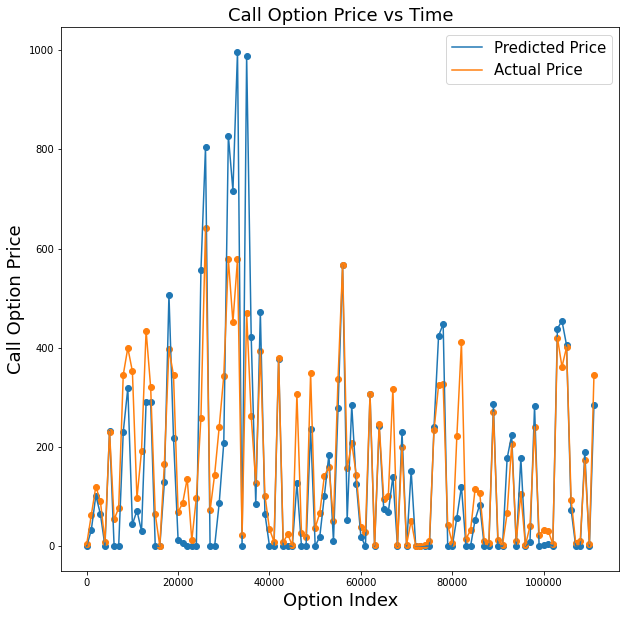

In [7]:
# Graph

y_scale = list(range(1, total_iterations_call + 1))
y_selected_points = []
BSM_selected_points = []
Actual_selected_points = []

plt.figure(figsize = (10, 10))
for i in range(len(y_scale)):
  if i%1000 == 0:
    y_selected_points.append(y_scale[i])
    BSM_selected_points.append(BSM_Price_Prediction_call[i])
    Actual_selected_points.append(Actual_Price_call[i])

plt.plot(y_selected_points, BSM_selected_points)
plt.plot(y_selected_points, Actual_selected_points)
plt.scatter(y_selected_points, BSM_selected_points)
plt.scatter(y_selected_points, Actual_selected_points)
plt.xlabel('Option Index', fontsize=18)
plt.ylabel('Call Option Price', fontsize=18)
plt.title('Call Option Price vs Time', fontsize=18)
plt.legend(["Predicted Price" , "Actual Price"], prop={"size":15})
plt.show()

### **Deep Learning Model**

In [8]:
# Normalizing X (input variables)

scaler = MinMaxScaler()
norm_df_call = scaler.fit_transform(df_call[['t', 'strike_price', 'underlying_value', 'sigma', 'r']], df_call['close'])
norm_df_call = pd.DataFrame(norm_df_call)
norm_df_call.rename(columns = {0:'t', 1:'strike_price', 2:'underlying_value', 3:'sigma', 4:'r'}, inplace = True)

In [9]:
# Splitting the dataset into testing and training sets
# T, Strike Price, Underlying Price are the X parameters
# Close is the y value
#Split Ratio = 80 (train) - 20 (test)

X_train, X_test, y_train, y_test = \
train_test_split(norm_df_call[['t', 'strike_price', 'underlying_value', 'sigma', 'r']], df_call['close'], test_size = 0.2, random_state = 42)

In [10]:
# Defining Variables

n_units = 400
layers = 4
n_batch = 128

In [11]:
# EarlyStopping Callback

cb_call = tf.keras.callbacks.EarlyStopping(\
    monitor = 'val_loss',\
    patience = 5,\
    restore_best_weights = True)

In [12]:
# Learning Rate Callback

LrCb_call = tf.keras.callbacks.ReduceLROnPlateau(\
    monitor = 'val_loss',\
    factor = 0.2,\
    patience = 3)

In [13]:
# Deep Learning model

model = Sequential()
model.add(Dense(n_units, input_dim = X_train.shape[1]))
model.add(LeakyReLU())

for i in range(layers - 1):
    model.add(Dense(n_units))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

model.add(Dense(1, activation = 'relu'))

model.compile(loss = 'mse', optimizer = Adam())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               2400      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 400)               160400    
                                                                 
 batch_normalization (BatchN  (None, 400)              1600      
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 400)               160400    
                                                        

In [14]:
# Fitting our data to the model

n_epochs = 30
history = model.fit(X_train, y_train, batch_size = n_batch, epochs = n_epochs, validation_split = 0.01,\
                    callbacks = [cb_call, LrCb_call], verbose = 1)

Epoch 1/30
693/693 [==============================] - 12s 16ms/step - loss: 14542.1797 - val_loss: 4630.3296 - lr: 0.0010
Epoch 2/30
693/693 [==============================] - 11s 16ms/step - loss: 2907.6353 - val_loss: 2587.5120 - lr: 0.0010
Epoch 3/30
693/693 [==============================] - 11s 16ms/step - loss: 2693.5190 - val_loss: 3161.8010 - lr: 0.0010
Epoch 4/30
693/693 [==============================] - 11s 16ms/step - loss: 2491.2554 - val_loss: 2693.0972 - lr: 0.0010
Epoch 5/30
693/693 [==============================] - 11s 16ms/step - loss: 2351.3606 - val_loss: 2543.7573 - lr: 0.0010
Epoch 6/30
693/693 [==============================] - 11s 16ms/step - loss: 2199.9114 - val_loss: 2461.4502 - lr: 0.0010
Epoch 7/30
693/693 [==============================] - 11s 16ms/step - loss: 2151.6365 - val_loss: 2548.1167 - lr: 0.0010
Epoch 8/30
693/693 [==============================] - 11s 16ms/step - loss: 2026.7941 - val_loss: 2128.4265 - lr: 0.0010
Epoch 9/30
693/693 [===========

In [15]:
# Predicting values for testing set

y_pred = model.predict(X_test)

In [16]:
# Evaluating model performance - MSE

MSE_call = (y_test.values - y_pred.reshape(y_pred.shape[0]))
DL_MSE_call = np.mean(np.square(MSE_call))
print(DL_MSE_call)

1023.1393216657375


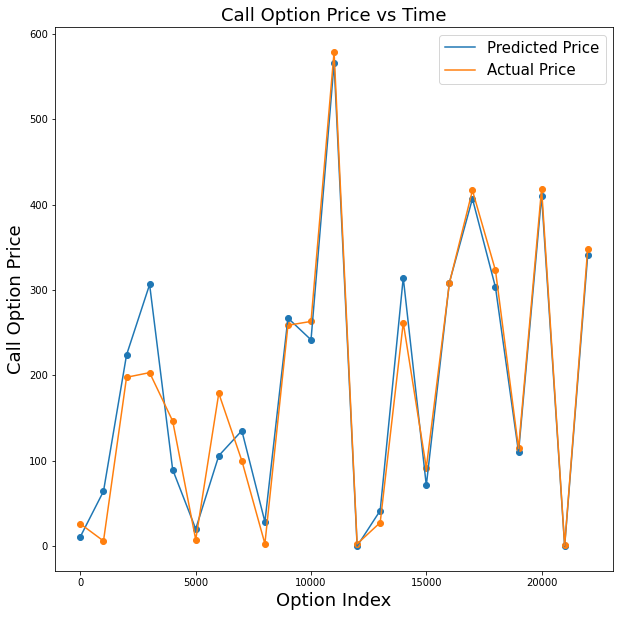

In [17]:
# Graph

y_scale = list(range(1, len(y_test.values)+1))
y_selected_points = []
DL_selected_points = []
Actual_selected_points = []

plt.figure(figsize = (10, 10))
for i in range(len(y_scale)):
  if i%1000 == 0:
    y_selected_points.append(y_scale[i])
    DL_selected_points.append(y_pred.reshape(y_pred.shape[0])[i])
    Actual_selected_points.append(y_test.values[i])

plt.plot(y_selected_points, DL_selected_points)
plt.plot(y_selected_points, Actual_selected_points)
plt.scatter(y_selected_points, DL_selected_points)
plt.scatter(y_selected_points, Actual_selected_points)
plt.xlabel('Option Index', fontsize=18)
plt.ylabel('Call Option Price', fontsize=18)
plt.title('Call Option Price vs Time', fontsize=18)
plt.legend(["Predicted Price" , "Actual Price"], prop={"size":15})
plt.show()

## **Put Options**

### **Black-Scholes-Merton (BSM) Model**

In [18]:
def d1(S, K, T, r, sigma):
    return (np.log(S/K)+(r+sigma**2/2)*T)/sigma*sqrt(T)

def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

def black_scholes_put(S,K,T,r,sigma):
    return K*exp(-r*T)*(1 - norm.cdf(d2(S,K,T,r,sigma))) - S*(1 - norm.cdf(d1(S,K,T,r,sigma)))

In [19]:
total_iterations_put = len(df_put)
BSM_Price_Prediction_put = np.zeros(total_iterations_put)
Actual_Price_put = np.zeros(total_iterations_put)

for i in range(total_iterations_put):
  S = df_put.iloc[i]['underlying_value']
  K = df_put.iloc[i]['strike_price']
  T = df_put.iloc[i]['t']/252
  r = df_put.iloc[i]['r']
  sigma = df_put.iloc[i]['sigma']
  BSM_Price_Prediction_put[i] = max(0, black_scholes_put(S, K, T, r, sigma))
  Actual_Price_put[i] = df_put.iloc[i]['close']

In [20]:
# Calculating the MSE

BSM_MSE_put = 0

for i in range(total_iterations_put):
  BSM_MSE_put = BSM_MSE_put + (Actual_Price_put[i] - BSM_Price_Prediction_put[i])**2

BSM_MSE_put = BSM_MSE_put/total_iterations_put
print(BSM_MSE_put)

8537.405058233906


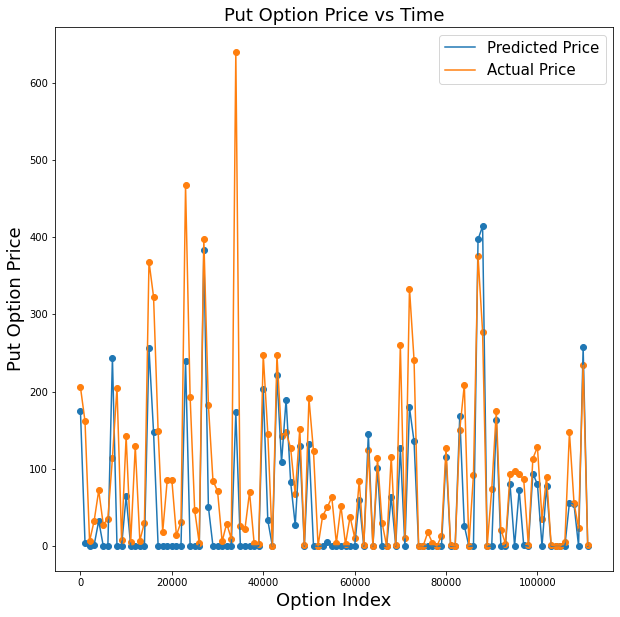

In [21]:
# Graph

y_scale = list(range(1, total_iterations_put + 1))
y_selected_points = []
BSM_selected_points = []
Actual_selected_points = []

plt.figure(figsize = (10, 10))
for i in range(len(y_scale)):
  if i%1000 == 0:
    y_selected_points.append(y_scale[i])
    BSM_selected_points.append(BSM_Price_Prediction_put[i])
    Actual_selected_points.append(Actual_Price_put[i])

plt.plot(y_selected_points, BSM_selected_points)
plt.plot(y_selected_points, Actual_selected_points)
plt.scatter(y_selected_points, BSM_selected_points)
plt.scatter(y_selected_points, Actual_selected_points)
plt.xlabel('Option Index', fontsize=18)
plt.ylabel('Put Option Price', fontsize=18)
plt.title('Put Option Price vs Time', fontsize=18)
plt.legend(["Predicted Price" , "Actual Price"], prop={"size":15})
plt.show()

### **Deep Learning Model**

In [22]:
scaler1 = MinMaxScaler()
norm_df_put = scaler1.fit_transform(df_put[['t', 'strike_price', 'underlying_value', 'sigma', 'r']], df_put['close'])
norm_df_put = pd.DataFrame(norm_df_put)
norm_df_put.rename(columns = {0:'t', 1:'strike_price', 2:'underlying_value', 3:'sigma', 4:'r'}, inplace = True)

In [23]:
# Splitting the dataset into testing and training sets
# T, Strike Price, Underlying Price are the X parameters
# Close is the y value
#Split Ratio = 80 (train) - 20 (test)

X_train, X_test, y_train, y_test = \
train_test_split(norm_df_put[['t', 'strike_price', 'underlying_value', 'sigma', 'r']], df_put['close'], test_size = 0.2, random_state = 42)

In [24]:
# Defining Variables

n_units = 400
layers = 5
n_batch = 128

In [25]:
# EarlyStopping Callback

cb_put = tf.keras.callbacks.EarlyStopping(\
    monitor = 'val_loss',\
    patience = 5,\
    restore_best_weights = True)

In [26]:
# Learning Rate Callback

LrCb_put = tf.keras.callbacks.ReduceLROnPlateau(\
    monitor = 'val_loss',\
    factor = 0.2,\
    patience = 3)

In [27]:
# Deep Learning model

model = Sequential()
model.add(Dense(n_units, input_dim = X_train.shape[1]))
model.add(LeakyReLU())

for i in range(layers - 1):
    model.add(Dense(n_units))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

model.add(Dense(1, activation = 'relu'))

model.compile(loss = 'mse', optimizer = Adam())

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 400)               2400      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 400)               160400    
                                                                 
 batch_normalization_3 (Batc  (None, 400)              1600      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 400)               0         
                                                                 
 dense_7 (Dense)             (None, 400)               160400    
                                                      

In [28]:
# Fitting our data to the model

n_epochs = 30
history = model.fit(X_train, y_train, batch_size = n_batch, epochs = n_epochs, validation_split = 0.01,\
                    callbacks = [cb_put, LrCb_put], verbose = 1)

Epoch 1/30
693/693 [==============================] - 15s 20ms/step - loss: 7835.8198 - val_loss: 5834.5635 - lr: 0.0010
Epoch 2/30
693/693 [==============================] - 14s 20ms/step - loss: 2511.4426 - val_loss: 2830.0425 - lr: 0.0010
Epoch 3/30
693/693 [==============================] - 14s 20ms/step - loss: 2265.0823 - val_loss: 1879.9020 - lr: 0.0010
Epoch 4/30
693/693 [==============================] - 14s 20ms/step - loss: 2188.1106 - val_loss: 2615.2563 - lr: 0.0010
Epoch 5/30
693/693 [==============================] - 14s 20ms/step - loss: 2098.7874 - val_loss: 2070.4749 - lr: 0.0010
Epoch 6/30
693/693 [==============================] - 14s 20ms/step - loss: 2024.4017 - val_loss: 2124.0303 - lr: 0.0010
Epoch 7/30
693/693 [==============================] - 14s 20ms/step - loss: 1811.2758 - val_loss: 1518.7972 - lr: 2.0000e-04
Epoch 8/30
693/693 [==============================] - 14s 20ms/step - loss: 1746.3192 - val_loss: 1520.5259 - lr: 2.0000e-04
Epoch 9/30
693/693 [====

In [29]:
# Predicting values for testing set

y_pred = model.predict(X_test)

In [30]:
# Evaluating model performance - MSE

MSE_put = (y_test.values - y_pred.reshape(y_pred.shape[0]))
DL_MSE_put = np.mean(np.square(MSE_put))
print(DL_MSE_put)

1141.3052793246384


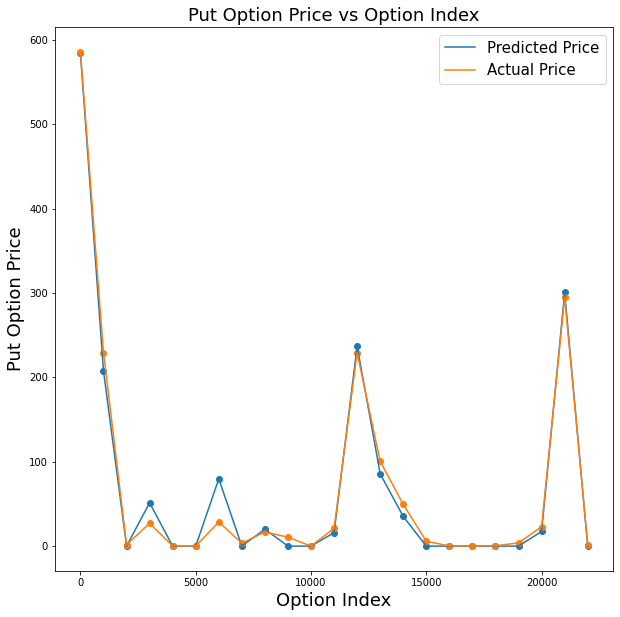

In [31]:
# Graph

y_scale = list(range(1, len(y_test.values)+1))
y_selected_points = []
DL_selected_points = []
Actual_selected_points = []

plt.figure(figsize = (10, 10))
for i in range(len(y_scale)):
  if i%1000 == 0:
    y_selected_points.append(y_scale[i])
    DL_selected_points.append(y_pred.reshape(y_pred.shape[0])[i])
    Actual_selected_points.append(y_test.values[i])

plt.plot(y_selected_points, DL_selected_points)
plt.plot(y_selected_points, Actual_selected_points)
plt.scatter(y_selected_points, DL_selected_points)
plt.scatter(y_selected_points, Actual_selected_points)
plt.xlabel('Option Index', fontsize=18)
plt.ylabel('Put Option Price', fontsize=18)
plt.title('Put Option Price vs Option Index', fontsize=18)
plt.legend(["Predicted Price" , "Actual Price"], prop={"size":15})
plt.show()

## **Comparing the Performances**

In [32]:
df_comp_dict = {}

df_comp_dict['Call Options'] = [BSM_MSE_call, DL_MSE_call, ((BSM_MSE_call - DL_MSE_call)/BSM_MSE_call) * 100]
df_comp_dict['Put Options'] = [BSM_MSE_put, DL_MSE_put, ((BSM_MSE_put - DL_MSE_put)/BSM_MSE_put) * 100]

df_comp = pd.DataFrame(df_comp_dict, index=['BSM', 'DL', '% Improvement'])
print(df_comp)

               Call Options  Put Options
BSM            10208.146685  8537.405058
DL              1023.139322  1141.305279
% Improvement     89.977227    86.631708
